Import Libs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import pandas as pd

from joblib import dump, load

from gamechanger import mdn_loss, MDNNetwork, TyreDegDataset

from datetime import datetime

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

In [2]:
cotaData = pd.read_csv(r"C:\Users\lordw\OneDrive\Documents\ML\MLprojects\F1hackTx\backend\data\mercedes_cota_2022_2024.csv")
cotaData.columns

Index(['timestamp', 'season', 'driver', 'lap_number', 'position',
       'interval_gap', 'flag_status', 'incident_message', 'lap_time',
       'push_signal', 'tyre_compound', 'stint_lap_count', 'tyre_wear_pct',
       'tyre_temp_C', 'engine_power_pct', 'throttle_pct', 'speed_kph',
       'drs_status', 'weather_condition', 'rainfall_mm', 'air_temperature_C',
       'fuel_load_kg'],
      dtype='object')

In [3]:
filtered_data = cotaData[cotaData['push_signal'] != 'DEGRADATION WARNING']

In [ ]:
dataset = TyreDegDataset(data=cotaData, seq_len=10)

In [5]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

dataset = TyreDegDataset(data=filtered_data, seq_len=10)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([64, 10, 14]) torch.Size([64])


In [25]:
seq_len = 10
num_features = filtered_data.shape[1] - len(['timestamp','driver','flag_status','push_signal','tyre_compound','drs_status','weather_condition','lap_time'])
in_dim = seq_len * num_features
action_dim = 3  # your 'MAINTAIN', 'PUSH', 'CONSERVE'
out_dim = 1     # predicting lap_time
latent_dim = 64
print(seq_len)
print(num_features)
print(in_dim)
print(action_dim)
print(out_dim)
print(latent_dim)
model = MDNNetwork(in_dim=in_dim, action_dim=action_dim, latent_dim=latent_dim, out_dim=out_dim)

10
14
140
3
1
64


In [19]:
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [20]:
X_batch, y_batch = next(iter(train_loader))
X_batch = X_batch.view(X_batch.size(0), -1)
y_batch = y_batch.view(-1, 1)
mu, sigma, pi = model(X_batch)
print(mu.shape, sigma.shape, pi.shape, y_batch.shape)

torch.Size([64, 3, 1]) torch.Size([64, 3, 1]) torch.Size([64, 3]) torch.Size([64, 1])


In [21]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        X_batch = X_batch.view(X_batch.size(0), -1)  # flatten
        y_batch = y_batch.view(-1, 1)                # ensure [B, 1]

        mu, sigma, pi = model(X_batch)
        loss = mdn_loss(y_batch, mu, sigma, pi)

        loss.backward()
        optimizer.step()

        
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/50, Train Loss: 53.6803
Epoch 2/50, Train Loss: 7.2751
Epoch 3/50, Train Loss: 8.5244
Epoch 4/50, Train Loss: 9.3068
Epoch 5/50, Train Loss: 9.8016
Epoch 6/50, Train Loss: 10.1119
Epoch 7/50, Train Loss: 10.2970
Epoch 8/50, Train Loss: 10.3932
Epoch 9/50, Train Loss: 10.4241
Epoch 10/50, Train Loss: 10.4048
Epoch 11/50, Train Loss: 10.3478
Epoch 12/50, Train Loss: 10.2624
Epoch 13/50, Train Loss: 10.1545
Epoch 14/50, Train Loss: 10.0279
Epoch 15/50, Train Loss: 9.8864
Epoch 16/50, Train Loss: 9.7319
Epoch 17/50, Train Loss: 9.5662
Epoch 18/50, Train Loss: 9.3900
Epoch 19/50, Train Loss: 9.2048
Epoch 20/50, Train Loss: 9.0111
Epoch 21/50, Train Loss: 8.8098
Epoch 22/50, Train Loss: 8.6015
Epoch 23/50, Train Loss: 8.3868
Epoch 24/50, Train Loss: 8.1665
Epoch 25/50, Train Loss: 7.9412
Epoch 26/50, Train Loss: 7.7116
Epoch 27/50, Train Loss: 7.4792
Epoch 28/50, Train Loss: 7.2475
Epoch 29/50, Train Loss: 7.0197
Epoch 30/50, Train Loss: 6.8047
Epoch 31/50, Train Loss: 6.6099
Epoch 3

In [22]:
model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.view(X_batch.size(0), -1)
        
        # reshape target
        y_batch = y_batch.view(-1, 1)
        
        mu, sigma, pi = model(X_batch)
        loss = mdn_loss(y_batch, mu, sigma, pi)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 6.3081


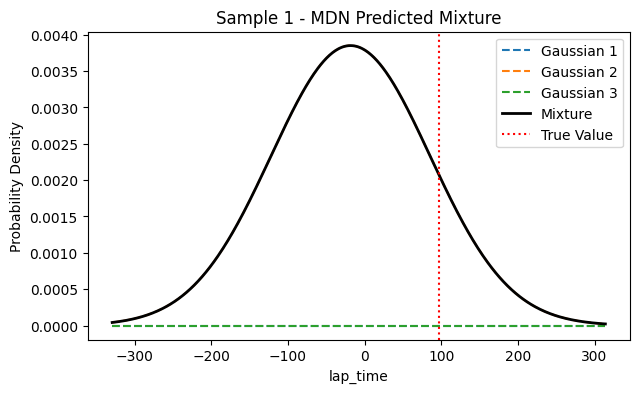

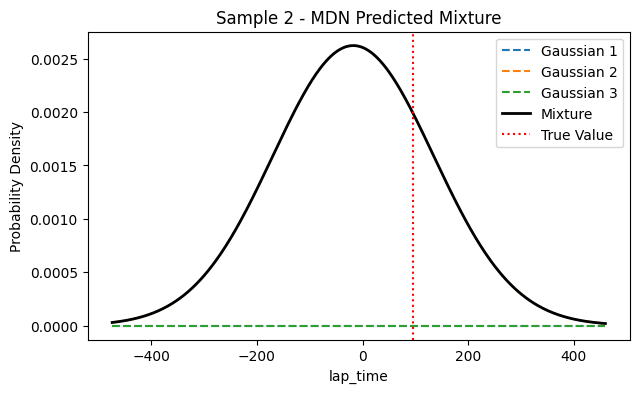

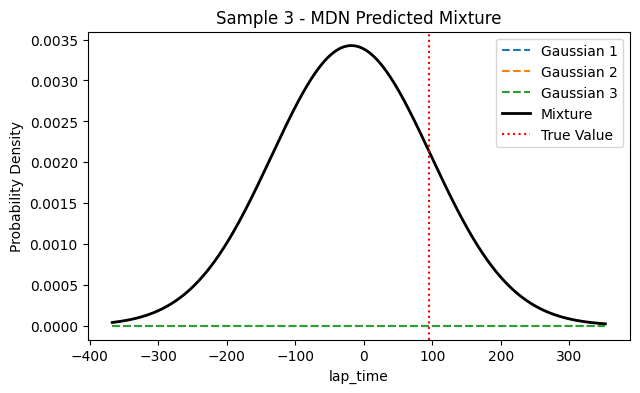

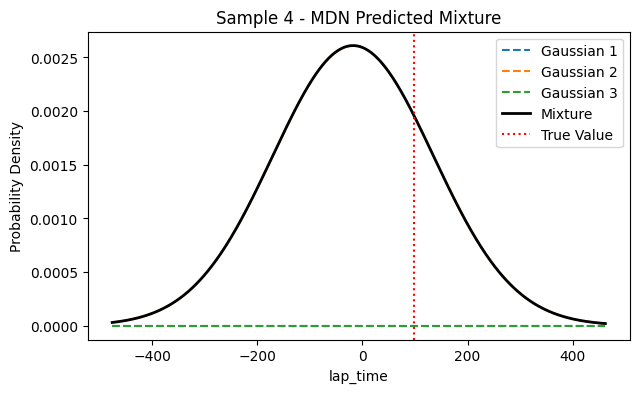

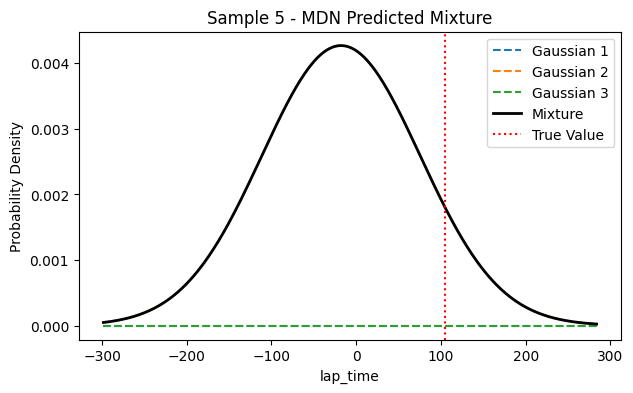

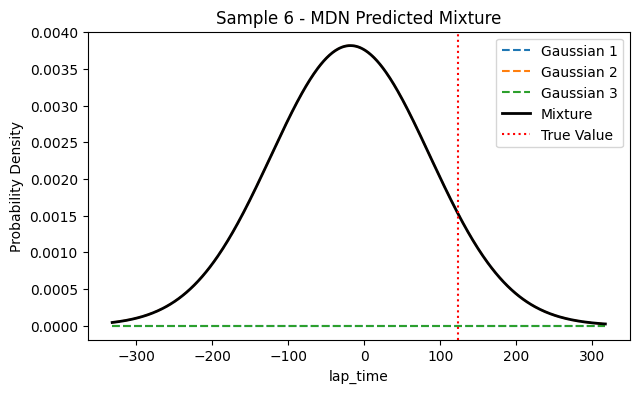

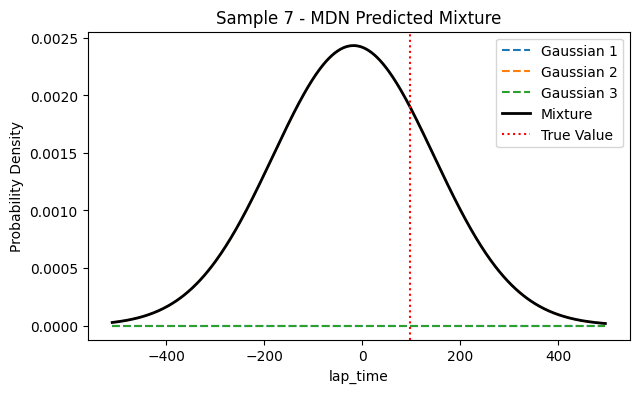

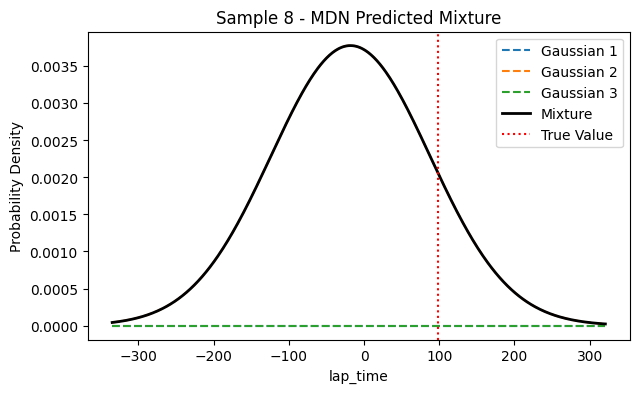

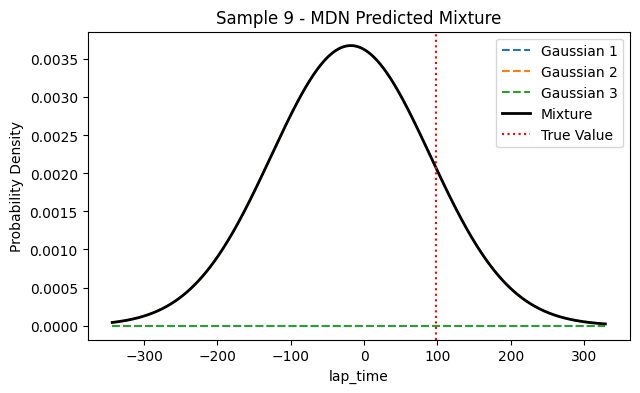

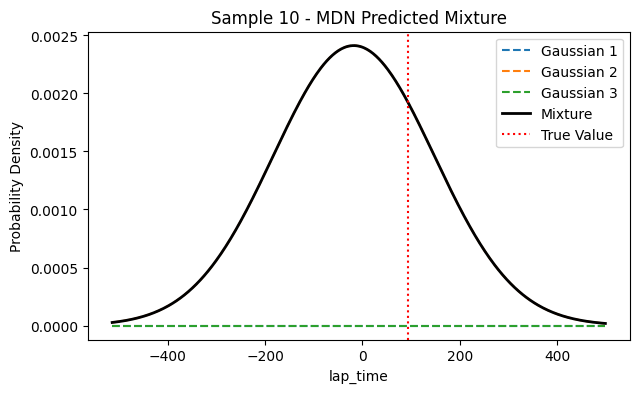

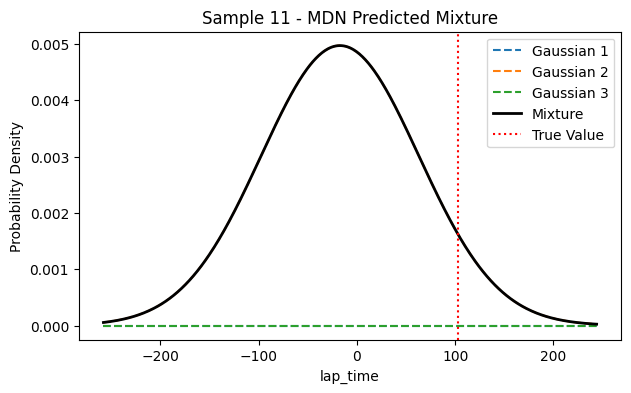

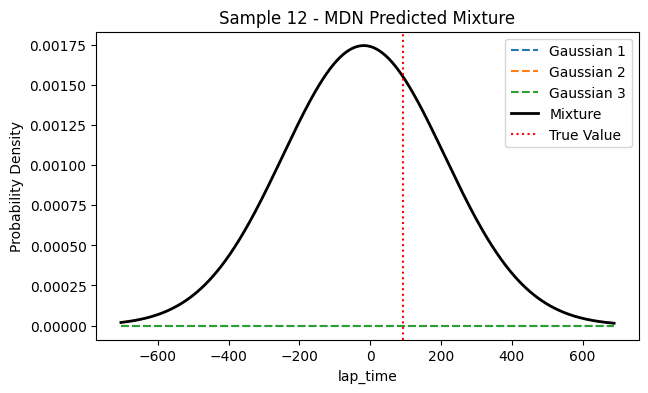

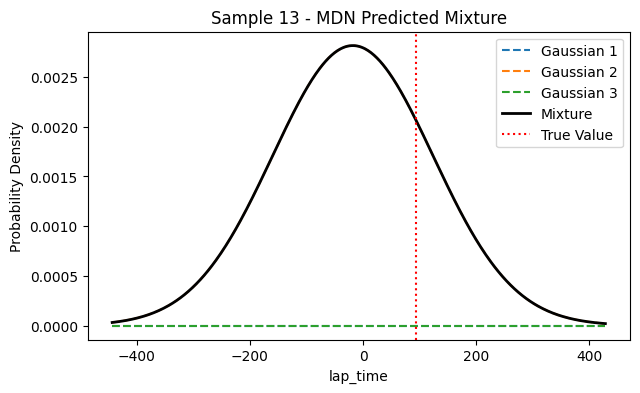

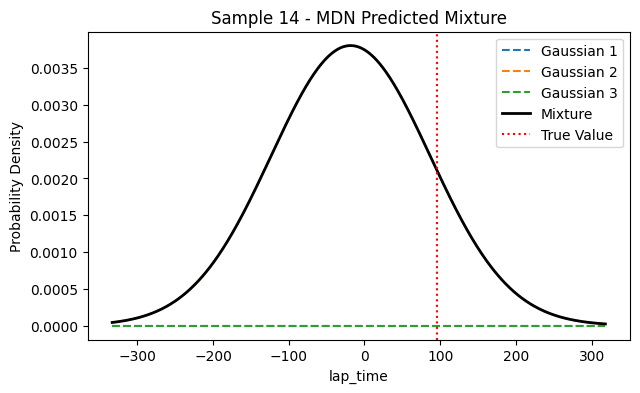

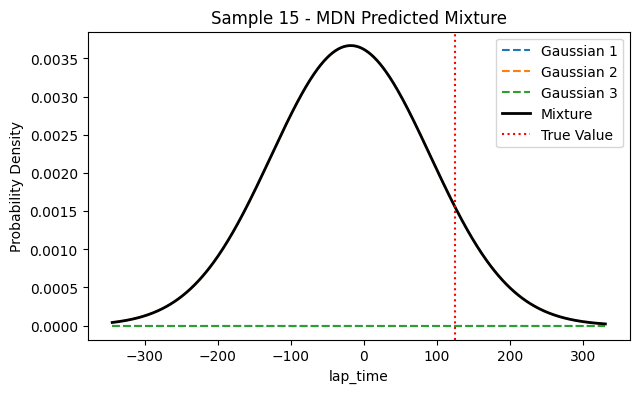

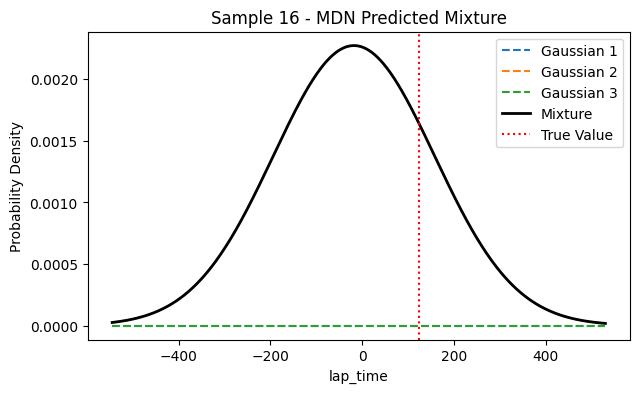

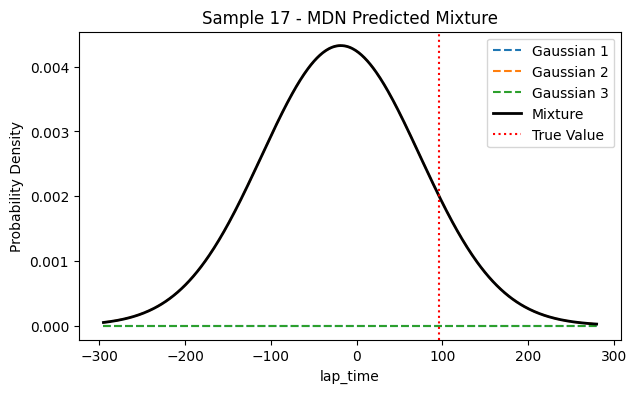

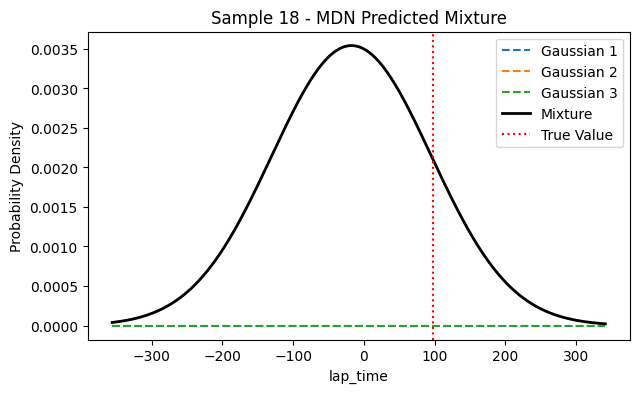

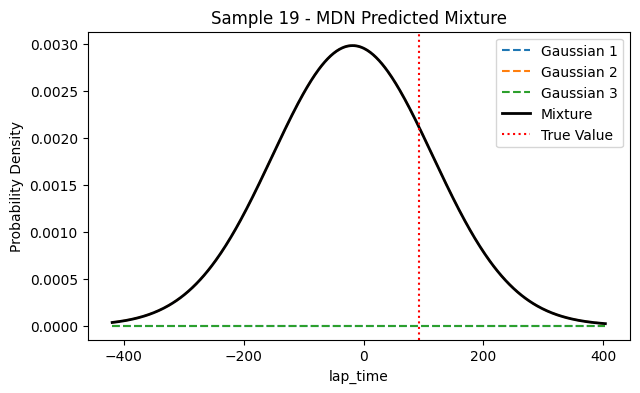

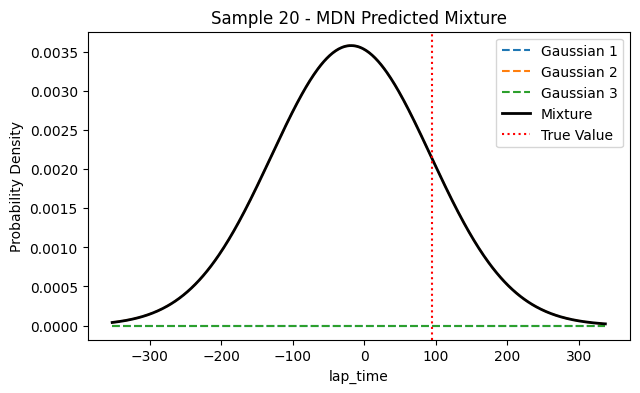

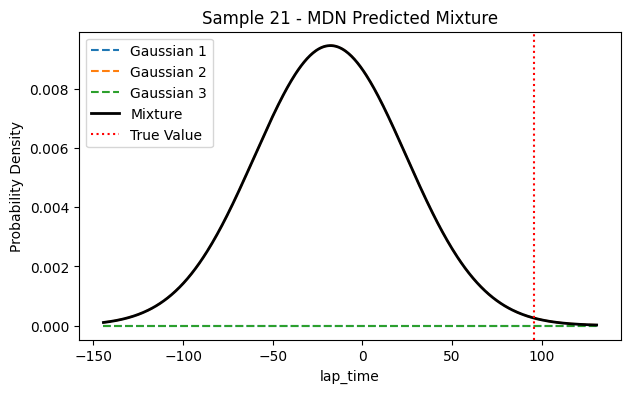

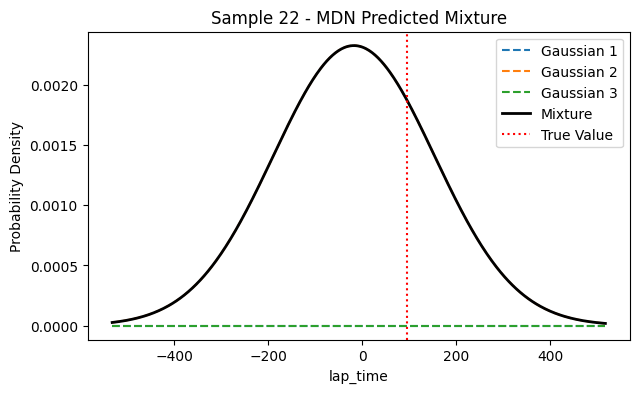

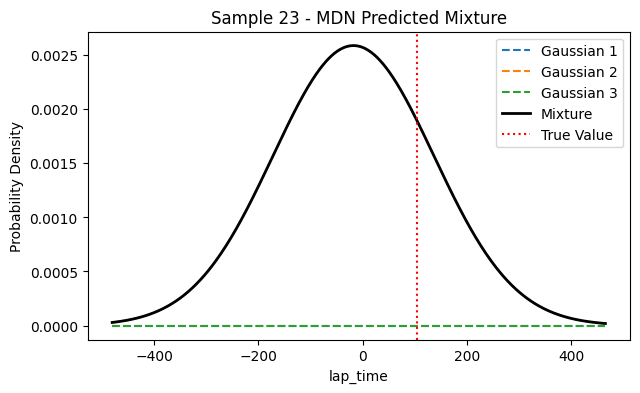

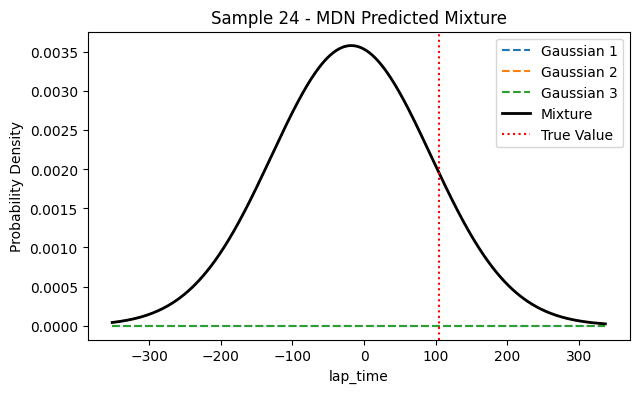

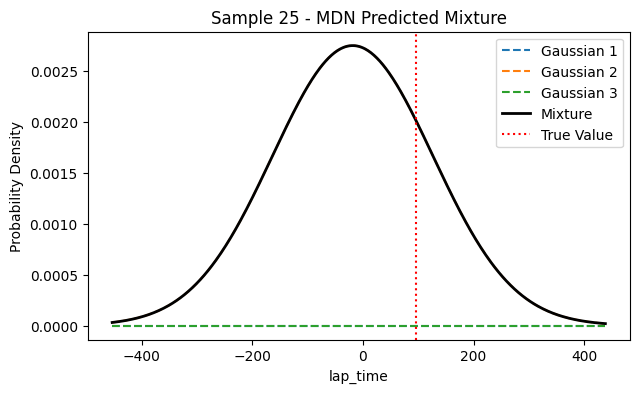

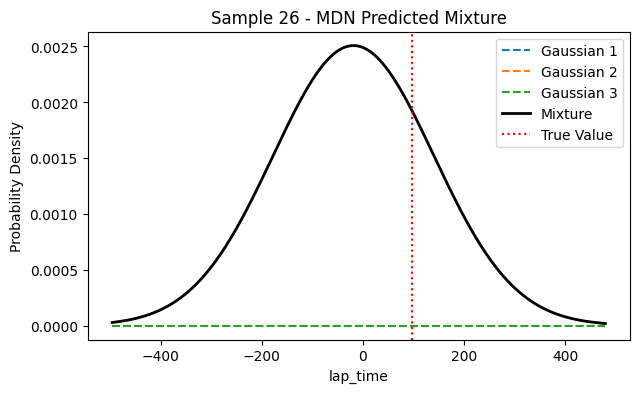

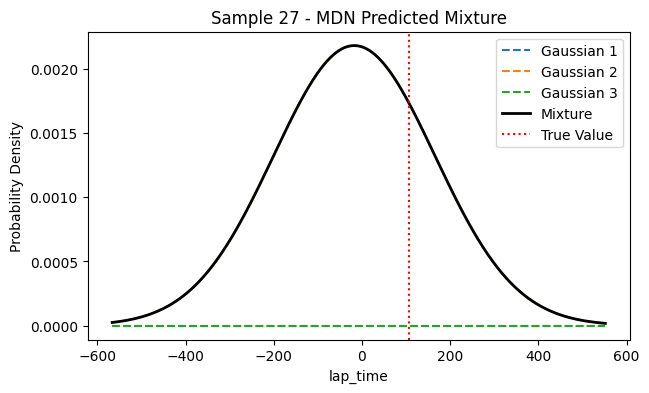

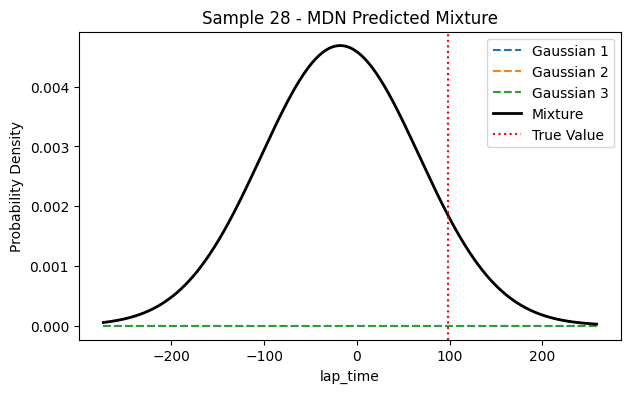

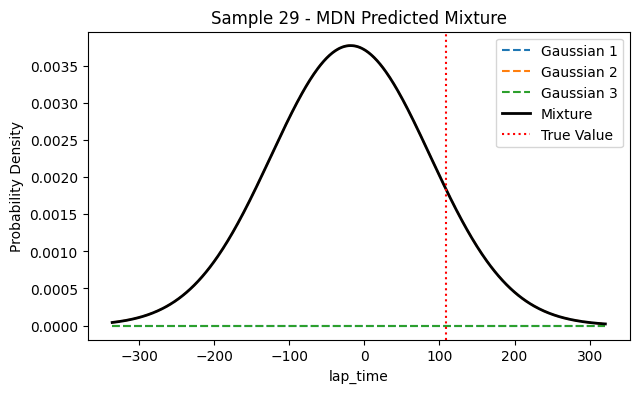

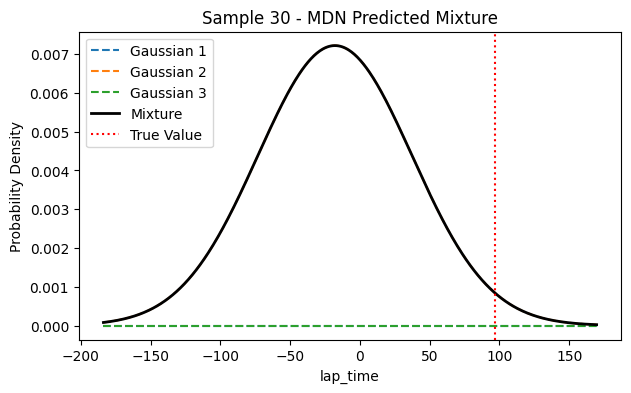

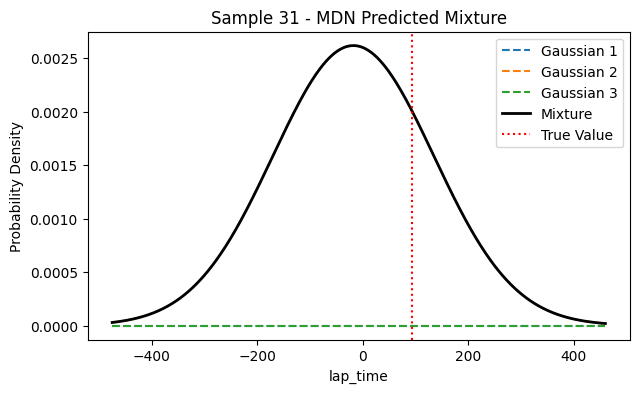

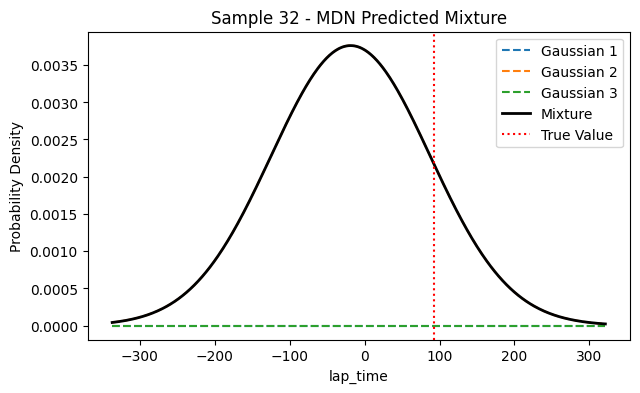

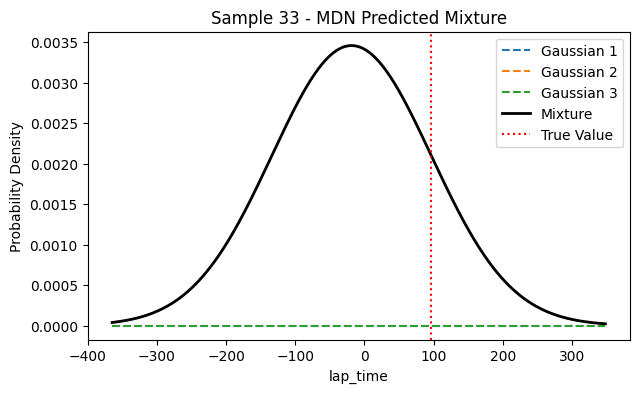

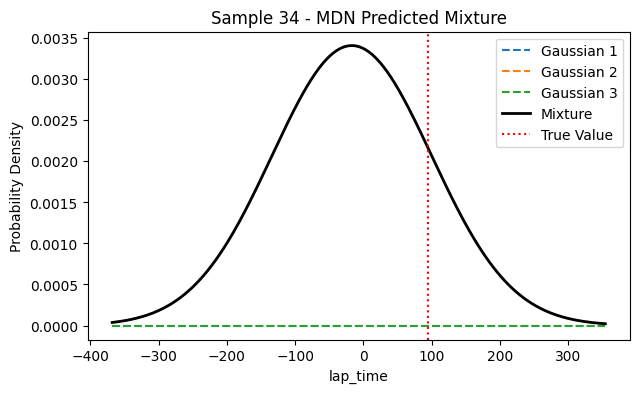

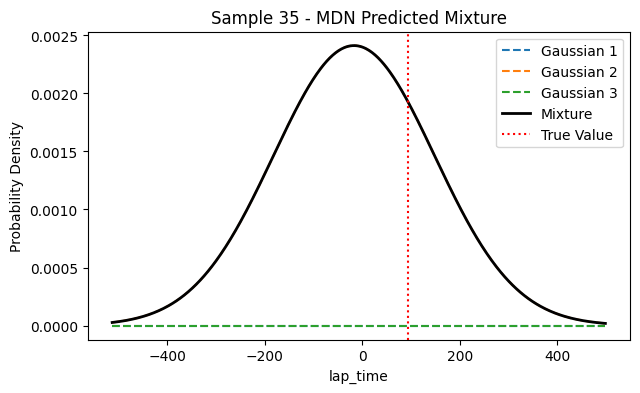

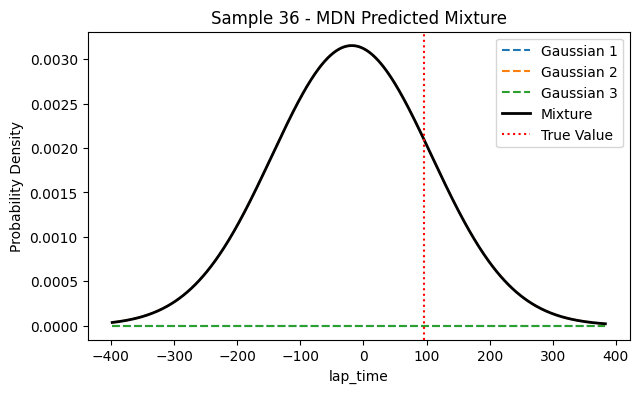

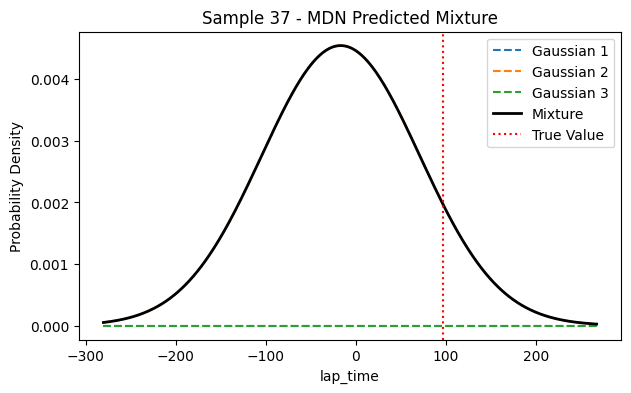

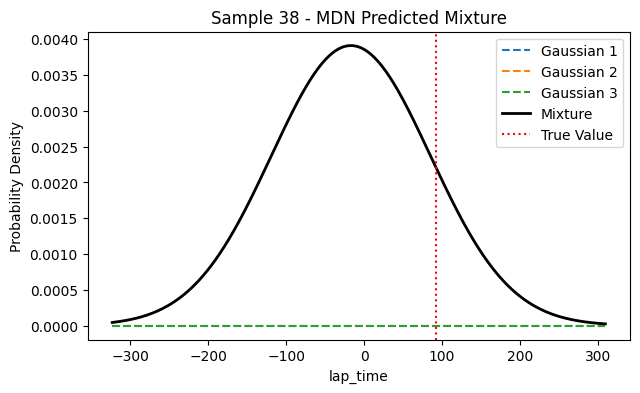

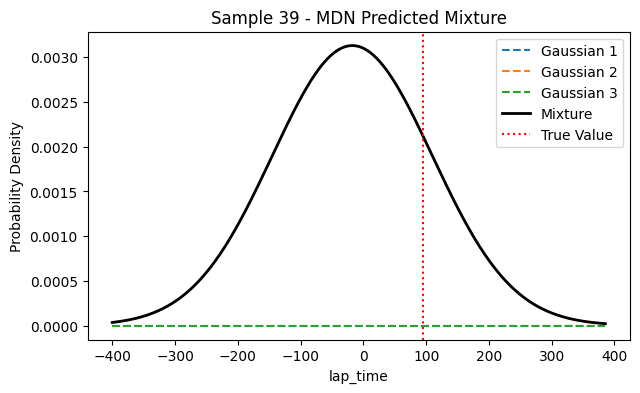

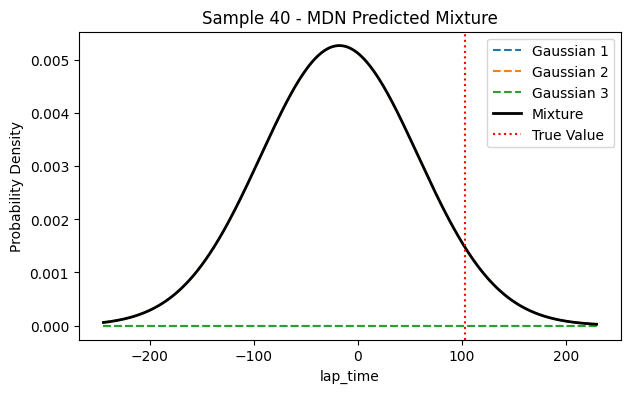

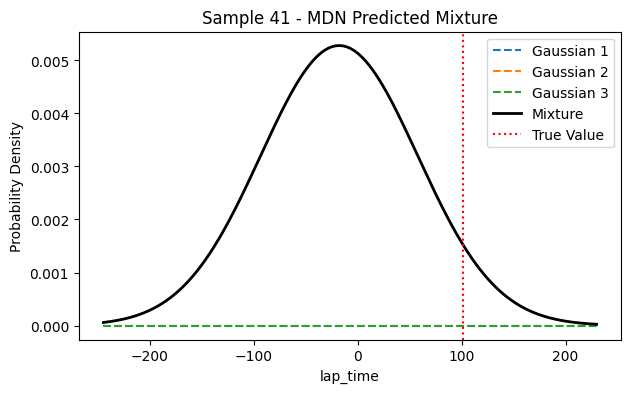

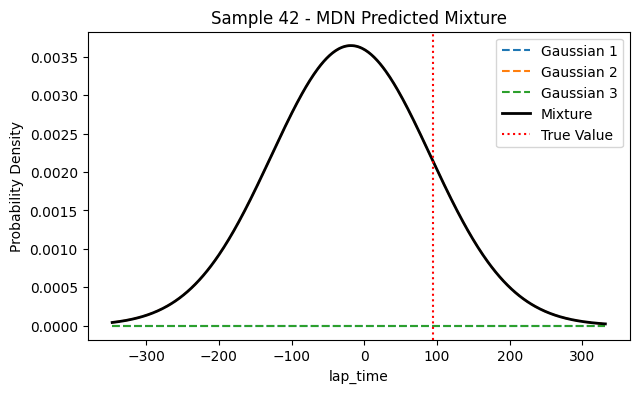

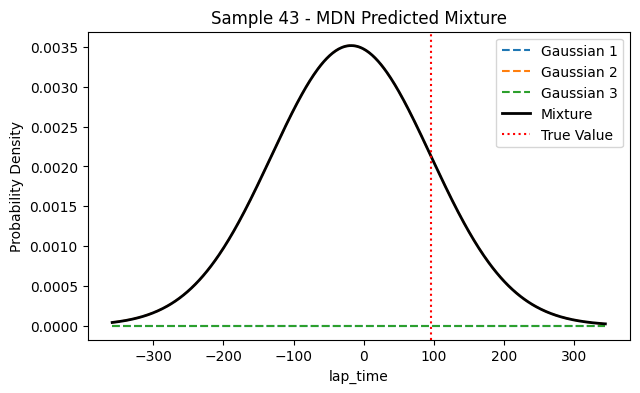

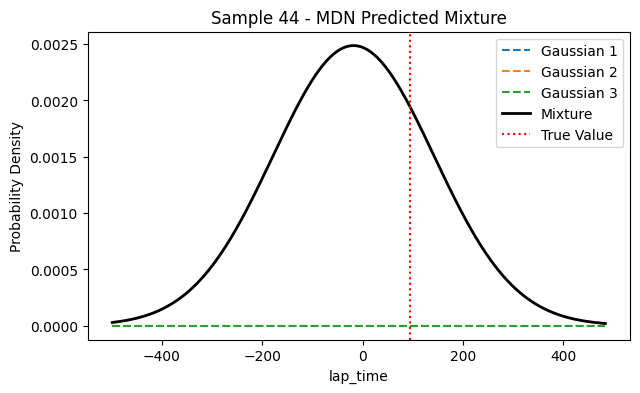

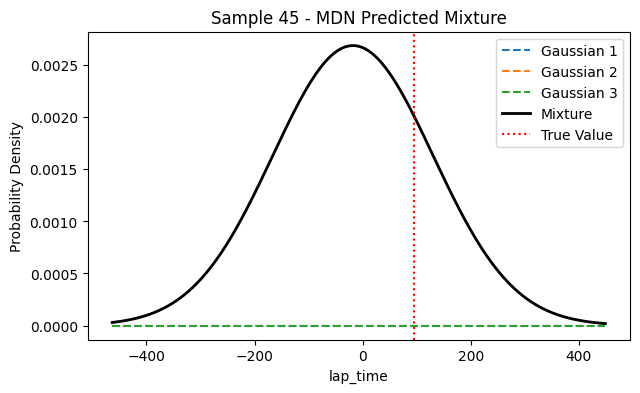

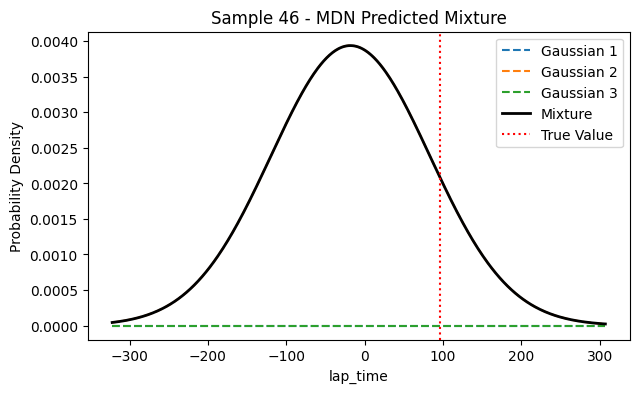

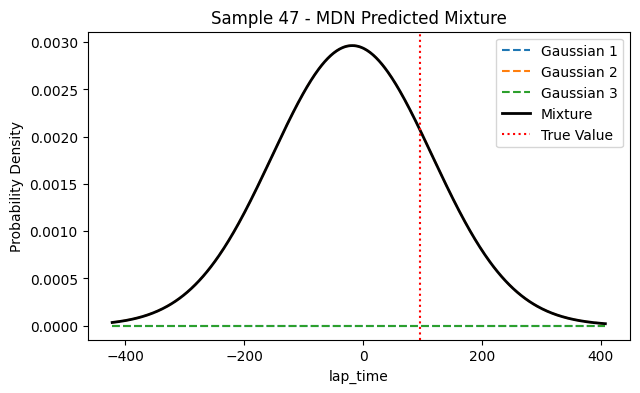

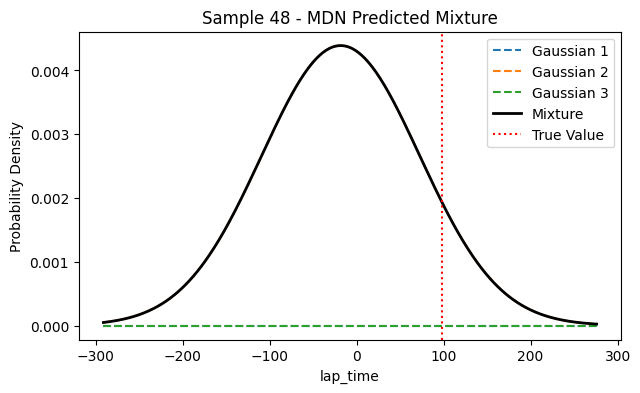

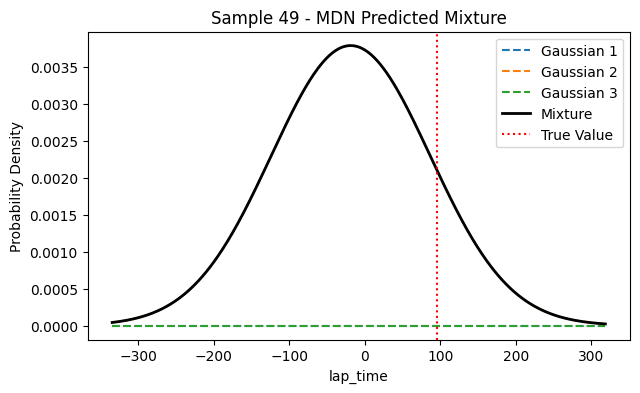

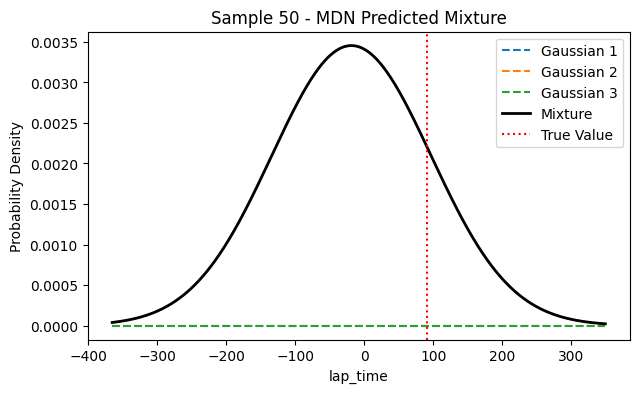

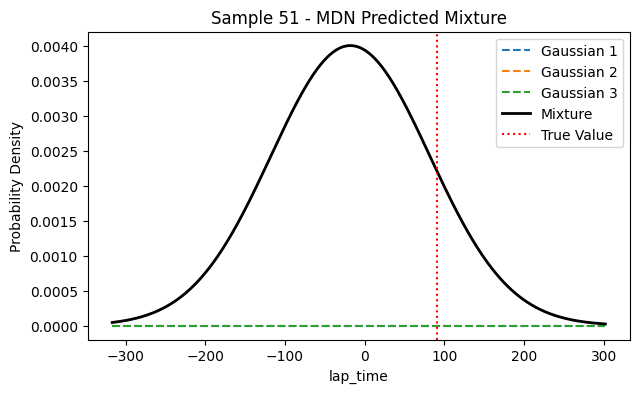

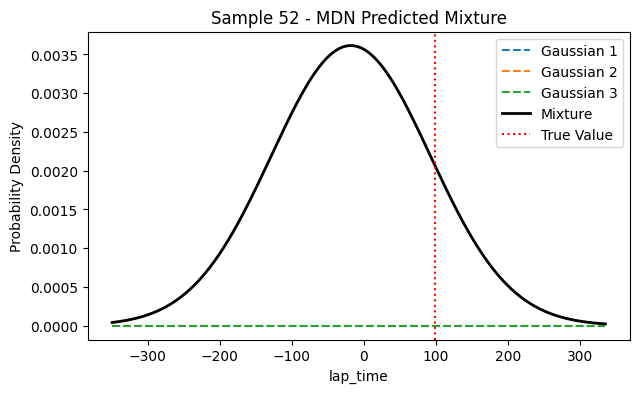

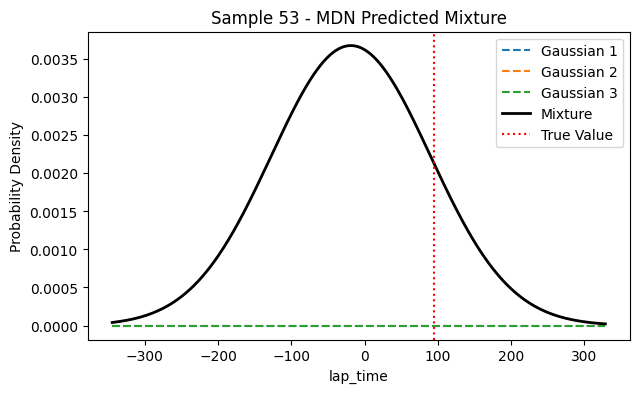

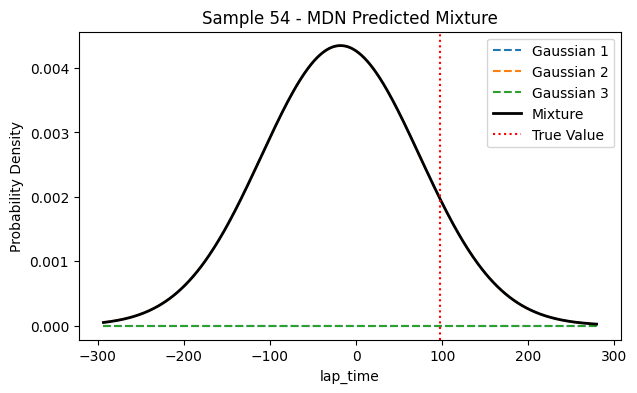

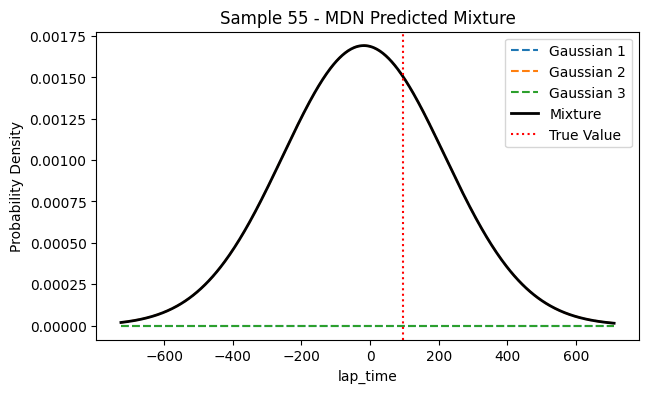

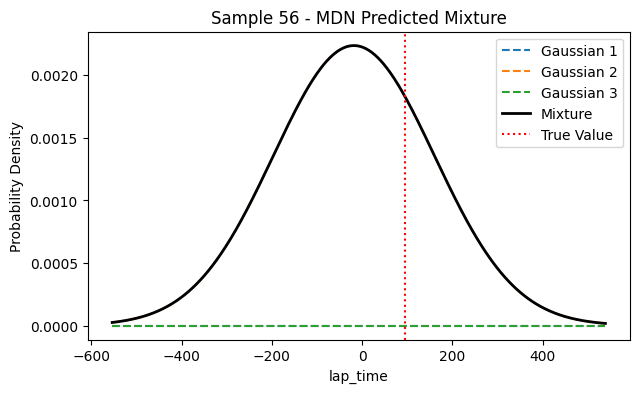

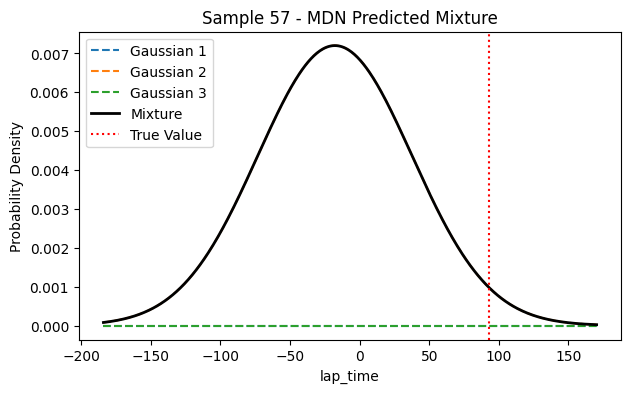

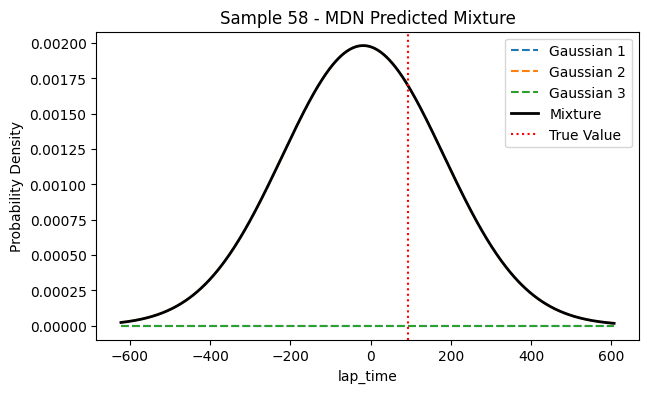

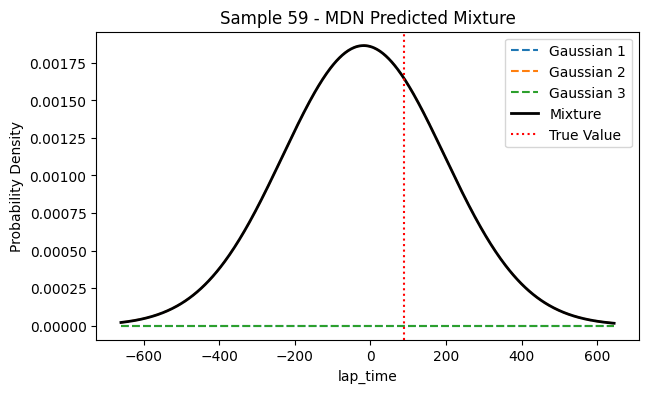

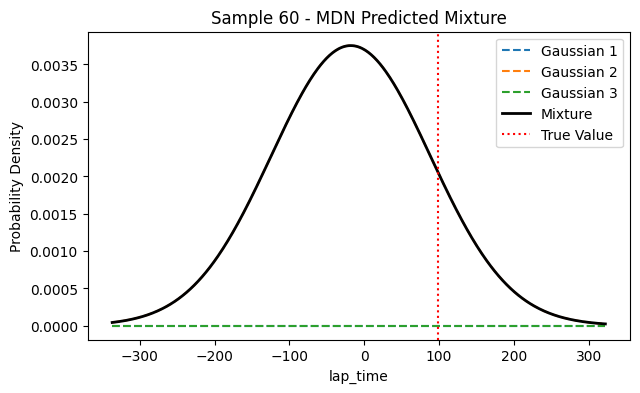

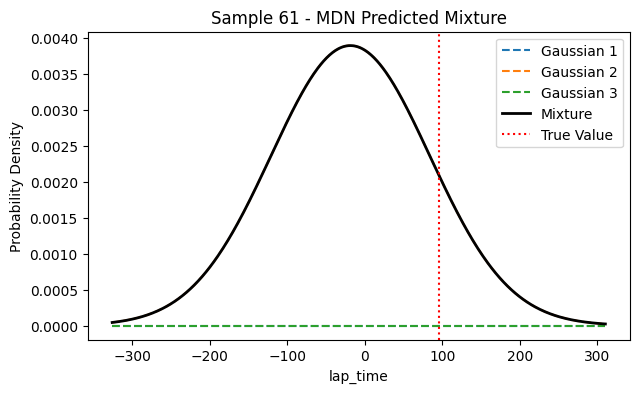

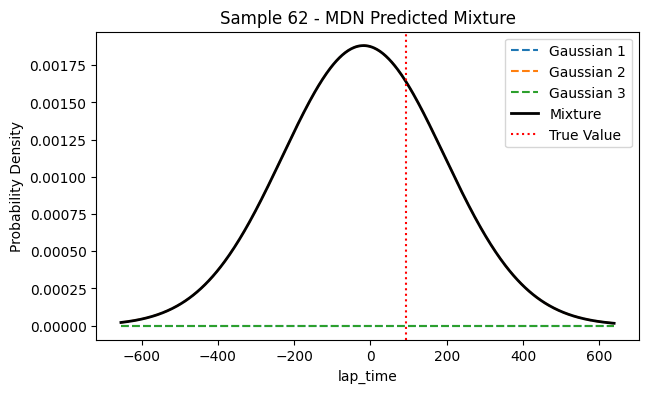

In [23]:
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_mdn_batch(model, X_batch, batch_labels=None):
    """
    Plot the MDN predicted mixture of Gaussians for a batch.
    
    Args:
        model: trained MDN model
        X_batch: [B, seq_len, feature_dim] tensor
        batch_labels: optional, true y values for comparison
    """
    model.eval()
    B = X_batch.size(0)
    
    # Flatten sequence
    X_batch_flat = X_batch.view(B, -1)
    
    with torch.no_grad():
        mu, sigma, pi = model(X_batch_flat)  # mu/sigma: [B, K, 1], pi: [B, K]
    
    K = mu.shape[1]
    
    for b in range(B):
        x_min = mu[b,:,0].min().item() - 3 * sigma[b,:,0].max().item()
        x_max = mu[b,:,0].max().item() + 3 * sigma[b,:,0].max().item()
        x = np.linspace(x_min, x_max, 500)
        
        y_total = np.zeros_like(x)
        plt.figure(figsize=(7,4))
        
        for k in range(K):
            mu_k = mu[b,k,0].item()
            sigma_k = sigma[b,k,0].item()
            pi_k = pi[b,k].item()
            
            y_k = pi_k * norm.pdf(x, mu_k, sigma_k)
            y_total += y_k
            plt.plot(x, y_k, linestyle='--', label=f'Gaussian {k+1}')
        
        plt.plot(x, y_total, color='black', linewidth=2, label='Mixture')
        
        if batch_labels is not None:
            plt.axvline(batch_labels[b].item(), color='red', linestyle=':', label='True Value')
        
        plt.title(f"Sample {b+1} - MDN Predicted Mixture")
        plt.xlabel("lap_time")
        plt.ylabel("Probability Density")
        plt.legend()
        plt.show()

# Example usage
X_batch, y_batch = next(iter(test_loader))
plot_mdn_batch(model, X_batch, batch_labels=y_batch)


In [24]:
torch.save(model.state_dict(), "mdn_model.pth")

In [ ]:
cotaData['timestamp'] = pd.to_datetime(cotaData['timestamp'])
cotaData = cotaData.sort_values('timestamp').reset_index(drop=True)

In [37]:
# --- Step 0: Ensure binary target ---
# Convert rainfall_mm to 0/1
cotaData['rain_binary'] = (cotaData['rainfall_mm'] > 0).astype(int)

# --- Parameters ---
window_size = 10      # number of laps in your window
lag = 10              # how many laps ahead to predict
rain_col = 'rain_binary'
predictor_cols = ['rainfall_mm', 'air_temperature_C']

features = []
targets = []

# --- Build windowed features and targets ---
for i in range(len(cotaData) - window_size - lag + 1):
    # Current window
    window_start = i
    window_end = i + window_size
    window = cotaData.iloc[window_start:window_end]
    
    # Flatten features across the window
    X_window = window[predictor_cols].values.flatten()
    
    # Target: rain 10 laps ahead
    target_idx = window_end + lag - 1
    y_window = cotaData.iloc[target_idx][rain_col]
    
    features.append(X_window)
    targets.append(y_window)

X = np.array(features)
y = np.array(targets)

# --- Train/test split (time series aware) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- Fit Logistic Regression ---
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
# --- Optional: class distribution check ---
print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))

Accuracy: 1.0
F1 score: 0.0
Confusion matrix:
 [[64]]
Train class distribution: [226  27]
Test class distribution: [64]


c:\Users\lordw\OneDrive\Documents\ML\MLprojects\F1hackTx\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\lordw\OneDrive\Documents\ML\MLprojects\F1hackTx\venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [39]:
# Save the model
dump(model, 'logistic_model.joblib')

['logistic_model.joblib']